In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [629]:
import datetime as dt
import scipy.stats as stats 

# Reflect Tables into SQLAlchemy ORM

In [327]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base() 
# reflect the tables
Base.prepare(engine, reflect=True) 

In [8]:
# We can view all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [184]:
# results = session.query(Measurement).all()

# for result in results:
#     print(result.date, result.prcp, result.station, result.id, result.tobs)

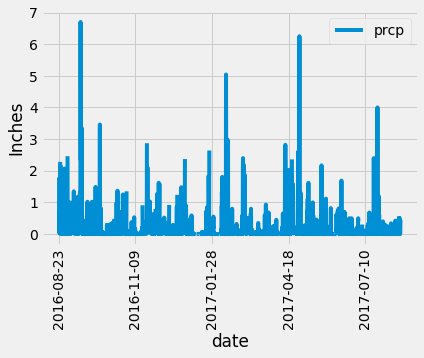

In [649]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_row = session.query(Measurement).order_by(Measurement.date.desc()).first()
last_row.__dict__

start_date = dt.date(2017,8,23) - dt.timedelta(days=365)
end_date = dt.date(2017,8,23)

# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date <= end_date , Measurement.date >= start_date).all()
#                     order_by(Measurement.date.desc()).all()
result
# # Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(result)
df
df = df.set_index('date')
# Sort the dataframe by date
df_sorted = df.sort_values('date')
df_sorted
# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot(rot=90)
plt.ylabel("Inches")
plt.show()

In [148]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [640]:
# Design a query to show how many stations are available in this dataset?

results = session.query(Measurement.station).distinct().count()
results

9

In [637]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]
count = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [238]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = count[0][0]
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
temperatures = session.query(*sel).filter(Measurement.station == most_active_station).all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

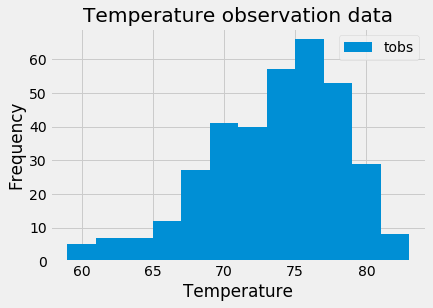

In [261]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
start_date = dt.date(2017,8,23) - dt.timedelta(days=365)
end_date = dt.date(2017,8,23)

result = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                     filter(Measurement.date <= end_date , Measurement.date >= start_date).all()
df = pd.DataFrame(result)

df.hist(bins = 12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature observation data")
plt.show()


## Bonus Challenge Assignment

## Temperature Analysis I 

In [636]:
june_avgtemp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
                             group_by(Measurement.station).\
                             filter(func.strftime("%m", Measurement.date) == "06").all()
dec_avgtemp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
                             group_by(Measurement.station).\
                             filter(func.strftime("%m", Measurement.date) == "12").all()

df_june = pd.DataFrame(june_avgtemp, columns=['Station','Avg tobs'])
df_dec = pd.DataFrame(dec_avgtemp, columns=['Station','Avg tobs'])

df_merged = pd.merge(df_june, df_dec, on = "Station", how = "outer")

stats.ttest_rel(df_merged['Avg tobs_x'],df_merged['Avg tobs_y'])

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

- A paired t-test was performed because the data is obtained from the same set just a different point in time. 
- The p-value obtained is 0.0001 which is less than 0.05 therefore, we can reject the null hypothese concluding that the differences in the means is statistically signifiant.

## Temperature Analysis II

In [643]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [644]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# trip_start_date = "2020-10-01"
# trip_end_date = "2020-10-15"

temp = calc_temps('2016-10-01', '2016-10-15')
temp

[(71.0, 77.78947368421052, 82.0)]

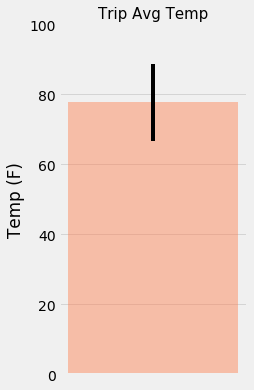

In [648]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# temp[0][1].plot(kind='bar', yerr=[temp[0][0],temp[0][2]] )
trip = '2019-04-08 to \n 2019-04-19'

min_temp = temp[0][0]
avg_temp = temp[0][1]
max_temp = temp[0][2]

errorBars = max_temp - min_temp

plt.figure(figsize=(3,6))
plt.bar(1, avg_Temp, yerr=errorBars, color = 'coral', alpha = .45)
plt.ylim(0, 100)
plt.xticks(range(1))
plt.title('Trip Avg Temp', fontsize =15)
plt.ylabel('Temp (F)')
plt.grid(alpha= 0.75)
plt.show()

## Daily Rainfall Average

In [527]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_date = "2016-10-01"
trip_end_date = "2016-10-15"

sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

results = session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date <= trip_end_date , Measurement.date >= trip_start_date).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).\
            all()
results
df_ = pd.DataFrame(results, columns=['Station','Name','Rainfall', 'Latitude', 'Longitude', 'Elevation'])
df_

,Station,Name,Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.21,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.75,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.30,21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,21.52130,-157.83740,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.07,21.33556,-157.71139,19.5
5,USC00517948,"PEARL CITY, HI US",0.07,21.39340,-157.97510,11.9
6,USC00519397,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0


In [440]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [546]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

trip_start_date = "2020-10-01"
trip_end_date = "2020-10-15"

# Use the start and end date to create a range of dates
mydates = pd.date_range(trip_start_date, trip_end_date)

# Stip off the year and save a list of %m-%d strings
mydates_md = mydates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in mydates_md]
normals


[[(69.0, 75.22916666666667, 80.0)],
 [(70.0, 76.26, 83.0)],
 [(66.0, 76.73076923076923, 84.0)],
 [(67.0, 75.86274509803921, 82.0)],
 [(67.0, 76.16666666666667, 84.0)],
 [(70.0, 75.42, 81.0)],
 [(68.0, 75.6078431372549, 81.0)],
 [(66.0, 76.3265306122449, 86.0)],
 [(69.0, 76.11363636363636, 84.0)],
 [(69.0, 75.85416666666667, 83.0)],
 [(69.0, 76.57142857142857, 84.0)],
 [(65.0, 75.75510204081633, 82.0)],
 [(65.0, 75.98039215686275, 84.0)],
 [(67.0, 75.1923076923077, 82.0)],
 [(67.0, 75.63461538461539, 82.0)]]

In [550]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripNormals = [(normal[0]) for normal in normals]
df_normal = pd.DataFrame(tripNormals, columns = ['Min Temp','Avg Temp','Max Temp'])
df_normal['Date'] = mydates
df_normal = df_normal.set_index('Date')
df_normal

,Min Temp,Avg Temp,Max Temp
Date,,,
2020-10-01,69.0,75.229167,80.0
2020-10-02,70.0,76.260000,83.0
2020-10-03,66.0,76.730769,84.0
2020-10-04,67.0,75.862745,82.0
2020-10-05,67.0,76.166667,84.0
2020-10-06,70.0,75.420000,81.0
2020-10-07,68.0,75.607843,81.0
2020-10-08,66.0,76.326531,86.0
2020-10-09,69.0,76.113636,84.0


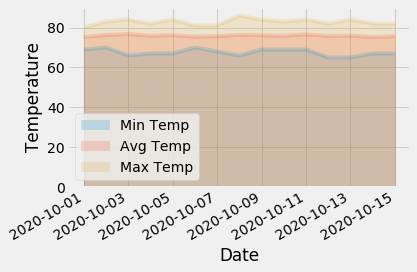

In [562]:
# Plot the daily normals as an area plot with `stacked=False`
df_normal.plot.area(stacked=False, alpha = 0.2, x_compat=True)
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()